# Sarcasm detection - MAIN CAS, modules text analytics and big data, Rita Fleer

Main sources:<br />
https://www.analyticsvidhya.com/blog/2022/02/text-data-augmentation-in-natural-language-processing-with-texattack/<br />
https://medium.com/codex/hands-on-data-augmentation-in-nlp-using-nlpaug-python-library-ad323c22908<br />


Installations:<br />
!pip install nlpaug<br />
!pip install textattack<br />

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

import contractions
from bs4 import BeautifulSoup
import re
import tqdm
import unicodedata

from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn import ensemble
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from termcolor import colored

#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import nltk

from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

import re

import tensorflow as tf
import tensorflow_hub as hub
import transformers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau


from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

import string
from multiprocessing import Pool
import time

import optuna
from optuna.trial import TrialState
from sklearn.metrics import accuracy_score
import plotly

from nltk.stem import WordNetLemmatizer
from fuzzywuzzy import fuzz
from deep_translator import GoogleTranslator
import nlpaug.augmenter.word as naw
import random
from textattack.augmentation import EasyDataAugmenter


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2024-01-01 11:30:42.473657: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 11:30:42.473703: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 11:30:42.473765: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 11:30:

# 1) Load and Clean data

Same as in main file


In [195]:
df = pd.read_json("data/Sarcasm_Headlines_Dataset_v2.json", lines=True)
del df['article_link'] # Deleting this column as it is of no use


df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [196]:
df.duplicated().sum()

116

In [197]:
df.drop_duplicates(inplace = True)

In [198]:
df.groupby("is_sarcastic").count().style.background_gradient(cmap = "autumn")

,headline
is_sarcastic,
0,14951
1,13552


In [199]:
headlines = df["headline"]
labels = df["is_sarcastic"]

train_hl, test_hl, train_l, test_l = model_selection.train_test_split(headlines, labels,
                                                                    test_size = 0.10,
                                                                    shuffle = True,
                                                                    random_state = 1)

train_hl, val_hl, train_l, val_l = model_selection.train_test_split(train_hl, train_l,
                                                                    test_size = 0.10,
                                                                    shuffle = True,
                                                                    random_state = 1)

len(train_hl), len(val_hl), len(test_hl)

(23086, 2566, 2851)

# 2) Data Augmentation

## 2a) Back translation

tried translators: googletrans, translate, google_trans_new, deep-translator

In [211]:
from deep_translator import GoogleTranslator

In [216]:
#example
translation = GoogleTranslator(source='en', target='de').translate(train_hl[101]) 
backtranslation = GoogleTranslator(source='de', target='en').translate(translation)

print('original: ', train_hl[101])
print('translation: ', translation)
print('back-transltaion: ', backtranslation) 

original:  study finds american diets are poor (but improving!)
translation:  Studie zeigt, dass die amerikanische Ernährung schlecht ist (aber sich verbessert!)
back-transltaion:  Study Shows American Diet Is Bad (But Is Getting Better!)


In [213]:
def back_translate_de_en(doc):
    translation = GoogleTranslator(source='en', target='de').translate(doc) 
    backtranslation = GoogleTranslator(source='de', target='en').translate(translation).lower()

    if backtranslation != doc:
        return backtranslation
    else:
        pass

In [192]:
# Sequential processing first 200 headlines
start_time = time.time()
back_translated_hl_s = list(train_hl[0:200].map(back_translate_de_en))
print(f"Time for preprocessing with single thread: {time.time() - start_time:.2f}s")

Time for preprocessing with single thread: 254.22s


In [214]:
#Parallel processing first 200 headlines
start_time = time.time()
hl = train_hl[0:200]
with Pool(12) as pool:
    back_translated_hl = pool.map(back_translate_de_en, hl, 10)

print(f"Time for preprocessing with multiprocessing: {time.time() - start_time:.2f}s")

Time for preprocessing with multiprocessing: 18.40s


In [209]:
back_translated_hl[0:10]

[None,
 'the report suggests that stalin was one major purge away from creating a communist utopia',
 'the threat to public health from private anger',
 'radicalized patagonia releases new fleece made from 100% recycled oil company ceos',
 'penis enlargement pills tested on dogs',
 None,
 "military apologizes after drone strike on yemen's isis base accidentally hits west palm beach wedding",
 "earth's overpopulation: will it create valuable new markets?",
 'gummy bears send 14 chicago-area high school students to the hospital',
 'guy in knitted hat at party calls beer a “libation”']

In [217]:
start_time = time.time()
hl = train_hl[0:5000]
with Pool(18) as pool:
    back_translated_hl = pool.map(back_translate_de_en, hl, 10)

print(f"Time for preprocessing with multiprocessing: {time.time() - start_time:.2f}s")

ConnectionError: None: Max retries exceeded with url: /m?tl=en&sl=de&q=Was+wir+bisher+%C3%BCber+das+neue+Organigramm+des+Wei%C3%9Fen+Hauses+wissen (Caused by None)

## 2b) NLP Aug and Textattack

### Preprocess

In [139]:
#headline preprocessing fuctions

def strip_html_tags(text): #probably irrelevant
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text): #probably irrelevant
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_headline(doc):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    doc = re.sub('[^\w\s]','',doc) #remove puctuation (added to original code)
    doc = re.sub('\d','',doc) #remove numbers (added to original code)
    # lower case and remove special characters\whitespaces 
    doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, flags=re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    return doc

In [259]:
start_time = time.time()

with Pool(6) as pool:
    train_hl_p = pool.map(pre_process_headline, train_hl, 200)

print(f"Time for preprocessing with multiprocessing: {time.time() - start_time:.2f}s")

with Pool(6) as pool:
    val_hl_p = pool.map(pre_process_headline, val_hl, 200)

with Pool(6) as pool:
    test_hl_p = pool.map(pre_process_headline, test_hl, 200)




Time for preprocessing with multiprocessing: 0.90s


### Synonym replacement

In [27]:
#synonym replacement example
syn_aug = naw.SynonymAug(aug_p=0.3)
sentence = 'climate change puts the squeeze on wine production'
mod_sentence = syn_aug.augment(sentence, n=1)
print('Original text :', sentence)
print('Augmented text :', mod_sentence)


Original text : climate change puts the squeeze on wine production
Augmented text : ['climate alteration redact the squeeze on wine output']


In [12]:
train_hl_p_s = train_hl_p.copy()

In [141]:
syn_aug = naw.SynonymAug(aug_p=0.8) #aug_p: how many words ber sentence are replaced with synonyms

for i,h in enumerate(train_hl_p_s):
    mod_sentence = syn_aug.augment(h, n=1) #how many sentences
    train_hl_p_s[i] = mod_sentence[0]

In [142]:
train_hl_p_s[0:10]

['franchesca ramseys back away menage for horn devotee monetary note value magnificent',
 'paper indicate chief joseph stalin cost scarce corresponding a pellet peerless greathearted regurgitation by from create commie sion',
 'the public health scourge of inscrutable anger',
 "radicalize patagonia put taboo fresh wool gain of recycled harlan fluorine. i. f. stone tilt candy petroleum ship ' s company chief lock officer",
 'phallus enlargement anovulatory drug demonstrate on weenie',
 "every tomboy template to hold up a mod artium magister ' be",
 'military apologizes after droning strike destine for yemeni inter spiritual service intelligence procedure al qaeda by lot bang west palm beach wedlock ceremonial social function',
 'overpopulation of the blase business concern vexation leave behind datum utilise science create valuable fresh market',
 'mucilaginous bear ship chicagoarea naughty pitch shot school twenty iv hour scholarly mortal to hospital',
 'boyfriend with apparent stitch 

In [143]:
#augment data set: choose a proportion of all sentences containing synonyms to append to original data set
def append_augmented_data(orig = train_hl_p, aug = train_hl_p_s, label = list(train_l), proportion=0.5):
    sample = random.sample(range(int(len(label))),int(len(label)*proportion))

    hl = orig.copy()
    l = label.copy()
    
    for n in sample:
        hl.append(aug[n])
        l.append(label[n])

    return hl, l

In [144]:
train_hl_p_aug, train_l_aug = append_augmented_data(proportion=1)

In [145]:
len(train_hl)

23086

In [146]:
len(train_hl_p_aug)

46172

In [148]:
pd.DataFrame(train_hl_p_aug).duplicated().sum()

61

In [150]:
df = pd.DataFrame({'headline':train_hl_p_aug, 'label':train_l_aug})
df.drop_duplicates(inplace = True)

In [151]:
df = df.sample(frac=1, random_state=42)

In [153]:
train_hl_p_aug = df['headline']
train_l_aug = df['label']

### Easy Augmenter

In [222]:
#example
eda_aug = EasyDataAugmenter(pct_words_to_swap=0.2, transformations_per_example=1)
eda_aug.augment("start each day with positive thoughts and make your day")

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


['thoughts each day with positive start and make your day']

In [262]:
train_hl_p_ea = train_hl_p.copy()

In [263]:
for i,h in enumerate(train_hl_p_ea):
    mod_sentence = eda_aug.augment(h) 
    train_hl_p_ea[i] = mod_sentence[0]

In [276]:
df2 = pd.DataFrame({'headline':train_hl_p + train_hl_p_ea, 'label':list(train_l) + list(train_l)})
df2.drop_duplicates(inplace = True)
df2 = df2.sample(frac=1, random_state=42)
train_hl_p_eag = df2['headline']
train_l_eag = df2['label']


### Other examples (unused)

In [279]:
sentence = 'climate change puts the squeeze on wine production'

#Random swap
aug = naw.random.RandomWordAug(action='swap', aug_p=0.3)
mod_sentence = aug.augment(sentence, n=1)
print('Original text :', sentence)
print('Augmented text :', mod_sentence)

Original text : climate change puts the squeeze on wine production
Augmented text : ['change climate puts squeeze on the wine production']


In [280]:
#random deletion/insertion
aug = naw.random.RandomWordAug(action='delete', aug_p=0.3)
mod_sentence = aug.augment(sentence, n=1)
print('Original text :', sentence)
print('Augmented text :', mod_sentence)

Original text : climate change puts the squeeze on wine production
Augmented text : ['climate puts squeeze wine production']


In [281]:
#Antonym Replacement
aug = naw.AntonymAug(aug_p=0.3)
mod_sentence = aug.augment(sentence, n=1)
print('Original text :', sentence)
print('Augmented text :', mod_sentence)

Original text : climate change puts the squeeze on wine production
Augmented text : ['climate change divest the squeeze on wine production']


In [282]:
#Augments text by replacing with synonyms from the WordNet thesaurus
from textattack.augmentation import WordNetAugmenter
wordnet_aug = WordNetAugmenter()
wordnet_aug.augment(sentence)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


['climate change puts the contract on wine production']

In [283]:
#Augments text by transforming words with their embeddings.
from textattack.augmentation import EmbeddingAugmenter
embed_aug = EmbeddingAugmenter()
embed_aug.augment(sentence)

['climate amendments puts the squeeze on wine production']

# 3) Logistic regression with NLPAug

In [154]:
train_hl = train_hl_p_aug
train_l = train_l_aug

cv = CountVectorizer(binary=False, min_df=2, max_df=1.0)

cv_train_features = cv.fit_transform(train_hl)
cv_test_features = cv.transform(test_hl)
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (46111, 29467)  Test features shape: (2851, 29467)


In [155]:
cv_train_features

<46111x29467 sparse matrix of type '<class 'numpy.int64'>'
	with 534742 stored elements in Compressed Sparse Row format>

In [156]:
%%time

# instantiate model 
#L2 = regularization, C = inverse of regularization strength, max_iter= Maximum number of iterations taken for the solvers to converge
#Limited-memory BFGS

lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

# train model
lr.fit(cv_train_features, train_l)

# predict on test data
lr_bow_predictions = lr.predict(cv_test_features)

CPU times: user 4.62 s, sys: 23.4 s, total: 28 s
Wall time: 2.6 s


In [157]:
print(classification_report(test_l, lr_bow_predictions))
pd.DataFrame(confusion_matrix(test_l, lr_bow_predictions))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1516
           1       0.82      0.84      0.83      1335

    accuracy                           0.84      2851
   macro avg       0.84      0.84      0.84      2851
weighted avg       0.84      0.84      0.84      2851



,0,1
0,1265,251
1,210,1125


In [21]:
misclassified_indices = np.where(lr_bow_predictions != test_l)[0]
#for index in misclassified_indices:
#    print(f"Instance {index + 1}, Headline: {norm_test_texts[index]} - Predicted: {lr_bow_predictions[index]}, Actual: {np.array(test_l)[index]}")

# 4) FastText Embeddings + CNN with NLP Aug

In [22]:
#!curl https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip -o data.zip

In [23]:
#!unzip data.zip

In [158]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(train_hl)
t.word_index['<PAD>'] = 0

In [159]:
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      t.word_index['<UNK>'])

('eyelet', 37624) ('<PAD>', 0) 1


In [160]:
train_sequences = t.texts_to_sequences(train_hl)
val_sequences = t.texts_to_sequences(val_hl)
test_sequences = t.texts_to_sequences(test_hl)

In [161]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=37625
Number of Documents=46111


(0.0, 30.0)

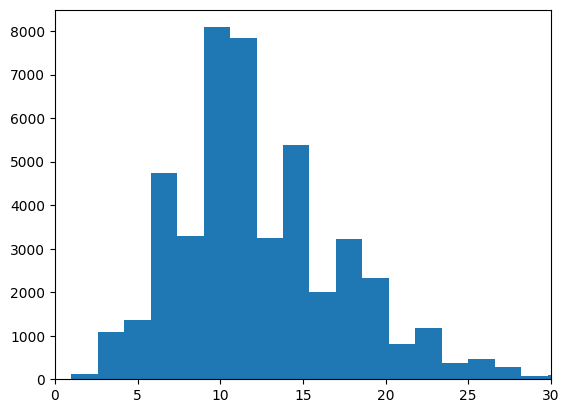

In [162]:
plt.hist([len(doc.split()) for doc in train_hl], bins=100);
plt.xlim([0, 30])

In [163]:
MAX_SEQUENCE_LENGTH = 20

# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((46111, 20), (2851, 20))

In [164]:
r = 100
print('Original headline: ', train_hl[r])
print('token sequence: ', train_sequences[r])
print('padded sequence: ', X_train[r])

Original headline:  drinking beer could help save this adorable red panda
token sequence:  [1289, 312, 5489, 5490, 6185, 7564, 6, 19644, 19645, 619, 365, 6, 1814, 513, 136, 136, 305]
padded sequence:  [    0     0     0  1289   312  5489  5490  6185  7564     6 19644 19645
   619   365     6  1814   513   136   136   305]


In [165]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './crawl-300d-2M-subword.vec'
VOCAB_SIZE = len(t.word_index)


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):    
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [166]:
EMBED_SIZE = 300

ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx, 
                                           max_features=VOCAB_SIZE, 
                                           embedding_size=EMBED_SIZE, 
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

(37625, 300)

In [167]:
# cnn model from exercises
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings], #use ft_embeddings here
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 300)           11287500  
                                                                 
 conv1d_4 (Conv1D)           (None, 20, 256)           307456    
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 10, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 10, 128)           131200    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 5, 64)            

In [168]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def model_training_evaluation(model = model, 
                             monitor = 'val_loss',
                             epochs = 10,
                             batch_size = 128,
                             patience = 2,
                             verbose = 1):
    # Fit the model
    es = tf.keras.callbacks.EarlyStopping(monitor=monitor, 
                                          patience=patience,
                                          restore_best_weights=True,
                                          verbose=verbose)
    
    history = model.fit(X_train, train_l, 
              validation_data=(X_val, val_l),
              epochs=epochs, 
              batch_size=batch_size, 
              shuffle=True,
              callbacks=[es],
              verbose=1)

    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')

    cnn_predictions = (model.predict(X_test)> 0.5).astype("int32")
    print("Accuracy: %.2f%%" % (accuracy_score(test_l, cnn_predictions)*100))
    print(classification_report(test_l, cnn_predictions))
    display(pd.DataFrame(confusion_matrix(test_l, cnn_predictions)))

    return cnn_predictions

Epoch 1/10
361/361 [==============================] - 20s 48ms/step - loss: 0.4167 - accuracy: 0.8004 - val_loss: 0.3084 - val_accuracy: 0.8706
Epoch 2/10
361/361 [==============================] - 6s 16ms/step - loss: 0.1473 - accuracy: 0.9445 - val_loss: 0.3759 - val_accuracy: 0.8597
Epoch 3/10
361/361 [==============================] - 4s 11ms/step - loss: 0.0292 - accuracy: 0.9896 - val_loss: 0.5674 - val_accuracy: 0.8500
Epoch 3: early stopping


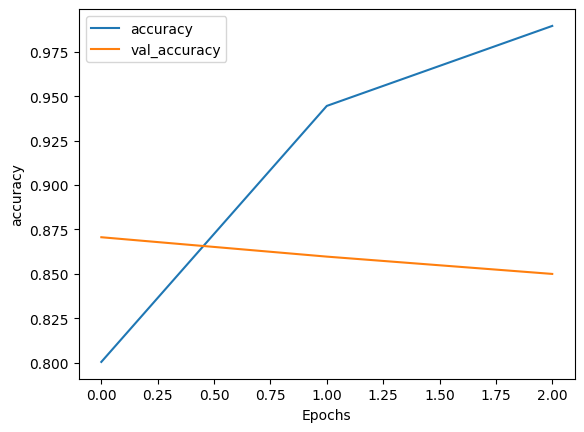

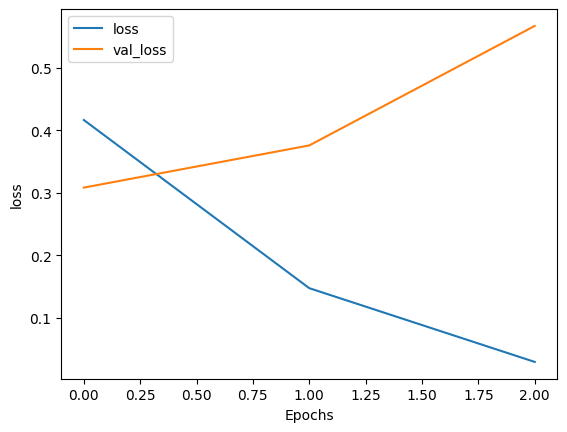

90/90 [==============================] - 0s 1ms/step
Accuracy: 85.79%
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1516
           1       0.82      0.89      0.85      1335

    accuracy                           0.86      2851
   macro avg       0.86      0.86      0.86      2851
weighted avg       0.86      0.86      0.86      2851



,0,1
0,1256,260
1,145,1190


In [169]:
cnn_predictions = model_training_evaluation()

In [178]:
# a much simpler model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings], #use ft_embeddings here
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 300)           11287500  
                                                                 
 conv1d_7 (Conv1D)           (None, 20, 10)            12010     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 10, 10)            0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 101       
                                                                 
Total params: 11299611 (43.10 MB)
Trainable params: 11299611 (43.10 MB)
Non-trainable params: 0 (0.00 Byte)
____________

Epoch 1/10
361/361 [==============================] - 3s 8ms/step - loss: 0.1517 - accuracy: 0.9411 - val_loss: 0.4316 - val_accuracy: 0.8527
Epoch 2/10
361/361 [==============================] - 3s 8ms/step - loss: 0.0307 - accuracy: 0.9890 - val_loss: 0.6247 - val_accuracy: 0.8402
Epoch 3/10
361/361 [==============================] - 3s 8ms/step - loss: 0.0125 - accuracy: 0.9957 - val_loss: 0.8937 - val_accuracy: 0.8418
Epoch 3: early stopping


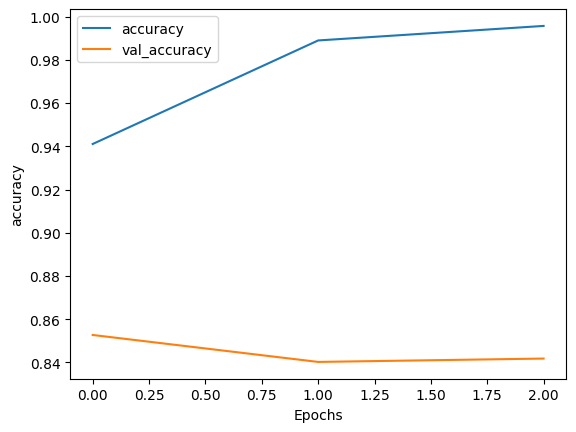

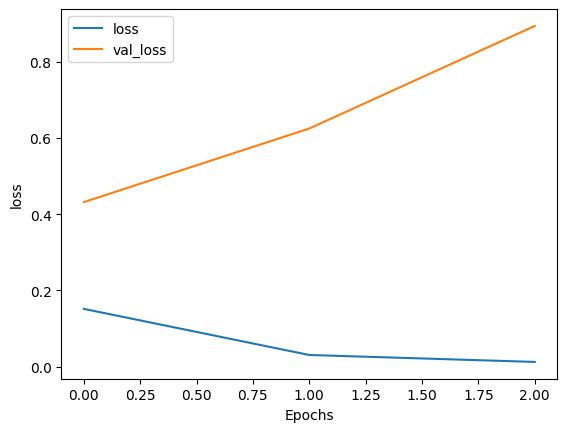

90/90 [==============================] - 0s 865us/step
Accuracy: 84.74%
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1516
           1       0.82      0.86      0.84      1335

    accuracy                           0.85      2851
   macro avg       0.85      0.85      0.85      2851
weighted avg       0.85      0.85      0.85      2851



,0,1
0,1271,245
1,190,1145


array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

In [179]:
model_training_evaluation()

In [180]:
#another much simpler model
EMBEDDING_SIZE = 5

model = Sequential()
model.add(Embedding(input_dim = VOCAB_SIZE,
                    output_dim=EMBEDDING_SIZE,
                    input_length=MAX_SEQUENCE_LENGTH,
                    name='embedding_layer'))
model.add(GRU(units=64,return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(l=1.367675698620851e-05)))
#model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 20, 5)             188125    
 )                                                               
                                                                 
 gru_2 (GRU)                 (None, 20, 64)            13632     
                                                                 
 dense_24 (Dense)            (None, 20, 1)             65        
                                                                 
Total params: 201822 (788.37 KB)
Trainable params: 201822 (788.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
361/361 [==============================] - 3s 8ms/step - loss: 0.0325 - accuracy: 0.9887 - val_loss: 0.6789 - val_accuracy: 0.8484
Epoch 2/10
361/361 [==============================] - 3s 7ms/step - loss: 0.0117 - accuracy: 0.9958 - val_loss: 1.0619 - val_accuracy: 0.8465
Epoch 3/10
361/361 [==============================] - 3s 7ms/step - loss: 0.0082 - accuracy: 0.9970 - val_loss: 1.2615 - val_accuracy: 0.8437
Epoch 4/10
361/361 [==============================] - 2s 7ms/step - loss: 0.0080 - accuracy: 0.9973 - val_loss: 1.1613 - val_accuracy: 0.8465
Epoch 5/10
361/361 [==============================] - 3s 7ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 1.0191 - val_accuracy: 0.8445
Epoch 6/10
361/361 [==============================] - 2s 7ms/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 1.2493 - val_accuracy: 0.8453
Epoch 7/10
361/361 [==============================] - 3s 7ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 1.7735 - val_accuracy: 0.8414
Epoch 

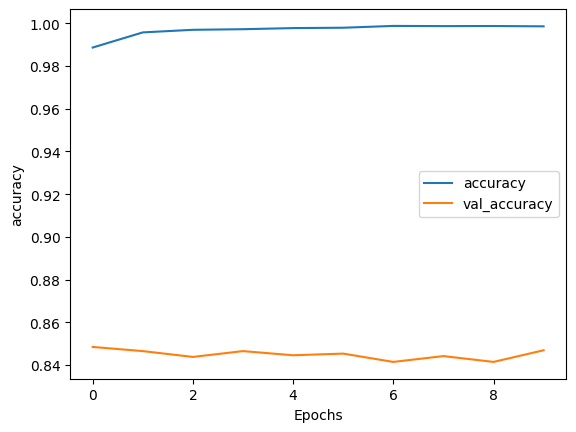

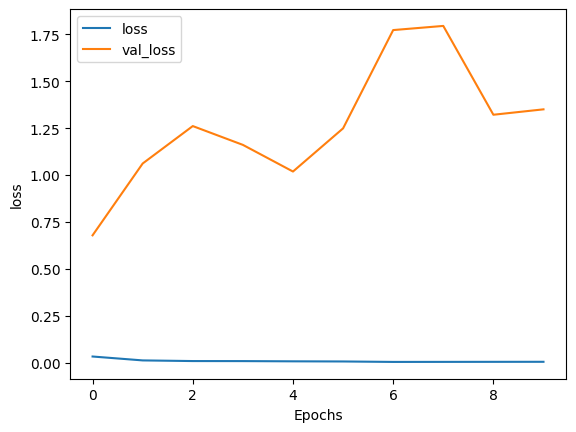

90/90 [==============================] - 0s 932us/step
Accuracy: 83.69%
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1516
           1       0.82      0.84      0.83      1335

    accuracy                           0.84      2851
   macro avg       0.84      0.84      0.84      2851
weighted avg       0.84      0.84      0.84      2851



,0,1
0,1267,249
1,216,1119


array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

In [181]:
model_training_evaluation(patience=10)

# 5) LSTM with NLP Aug

In [182]:
VOCAB_SIZE = len(t.word_index)
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # the number of hidden units in each LSTM cell; total LSTM cells = sequence length (num of tokens)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                    output_dim=EMBEDDING_DIM, 
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.SpatialDropout1D(0.1)) #optional

model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model.add(tf.keras.layers.Dense(256, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 20, 300)           11287500  
                                                                 
 spatial_dropout1d_2 (Spati  (None, 20, 300)           0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 128)               219648    
                                                                 
 dense_25 (Dense)            (None, 256)               33024     
                                                                 
 dense_26 (Dense)            (None, 1)                 257       
                                                                 
Total params: 11540429 (44.02 MB)
Trainable params: 11540429 (44.02 MB)
Non-trainable params: 0 (0.00 Byte)
____________

Epoch 1/10
361/361 [==============================] - 3s 7ms/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 1.3547 - val_accuracy: 0.8394
Epoch 2/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 1.3591 - val_accuracy: 0.8383
Epoch 3/10
361/361 [==============================] - 2s 7ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 1.7751 - val_accuracy: 0.8496
Epoch 3: early stopping


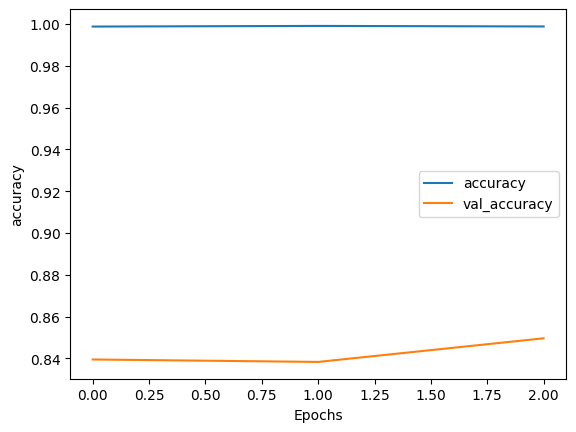

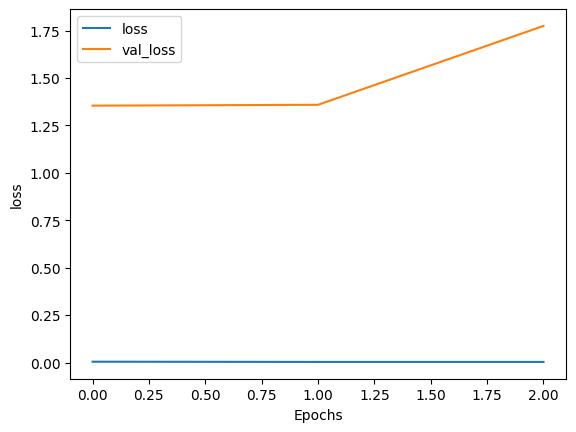

90/90 [==============================] - 0s 1ms/step
Accuracy: 83.34%
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1516
           1       0.84      0.79      0.82      1335

    accuracy                           0.83      2851
   macro avg       0.83      0.83      0.83      2851
weighted avg       0.83      0.83      0.83      2851



,0,1
0,1317,199
1,276,1059


In [183]:
lstm_predictions = model_training_evaluation()

In [184]:
#Implement best model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                    output_dim=105, 
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.SpatialDropout1D(0.6)) #optional

model.add(tf.keras.layers.LSTM(85, return_sequences=False))

model.add(tf.keras.layers.Dense(81, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.4)) 
model.add(tf.keras.layers.Dense(108, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.1)) 
model.add(tf.keras.layers.Dense(53, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.4)) 

model.add(tf.keras.layers.Dense(109, activation='swish'))
model.add(tf.keras.layers.Dropout(rate = 0.4)) 
model.add(tf.keras.layers.Dense(41, activation='swish'))
model.add(tf.keras.layers.Dropout(rate = 0.4)) 

model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 20, 105)           3950625   
                                                                 
 spatial_dropout1d_3 (Spati  (None, 20, 105)           0         
 alDropout1D)                                                    
                                                                 
 lstm_3 (LSTM)               (None, 85)                64940     
                                                                 
 dense_27 (Dense)            (None, 81)                6966      
                                                                 
 dropout_87 (Dropout)        (None, 81)                0         
                                                                 
 dense_28 (Dense)            (None, 108)               8856      
                                                     

In [185]:
val_ds = (X_val, val_l)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1,min_lr=1e-05,verbose=0)
early_stoping = EarlyStopping(monitor="val_loss",min_delta=0,patience=5,verbose=0,mode="auto", baseline=None,restore_best_weights=True)

histroy = model.fit(X_train, train_l, validation_data=val_ds,epochs=27,callbacks=[reduce_lr,early_stoping],verbose=1,
                    batch_size=16)

Epoch 1/27
2882/2882 [==============================] - 28s 9ms/step - loss: 0.4761 - accuracy: 0.7759 - val_loss: 0.3426 - val_accuracy: 0.8472 - lr: 0.0010
Epoch 2/27
2882/2882 [==============================] - 16s 6ms/step - loss: 0.2722 - accuracy: 0.8932 - val_loss: 0.3566 - val_accuracy: 0.8484 - lr: 0.0010
Epoch 3/27
2882/2882 [==============================] - 16s 6ms/step - loss: 0.1391 - accuracy: 0.9498 - val_loss: 0.3993 - val_accuracy: 0.8480 - lr: 1.0000e-04
Epoch 4/27
2882/2882 [==============================] - 16s 5ms/step - loss: 0.1235 - accuracy: 0.9579 - val_loss: 0.4192 - val_accuracy: 0.8492 - lr: 1.0000e-05
Epoch 5/27
2882/2882 [==============================] - 16s 5ms/step - loss: 0.1225 - accuracy: 0.9571 - val_loss: 0.4242 - val_accuracy: 0.8496 - lr: 1.0000e-05
Epoch 6/27
2882/2882 [==============================] - 16s 5ms/step - loss: 0.1199 - accuracy: 0.9577 - val_loss: 0.4235 - val_accuracy: 0.8488 - lr: 1.0000e-05


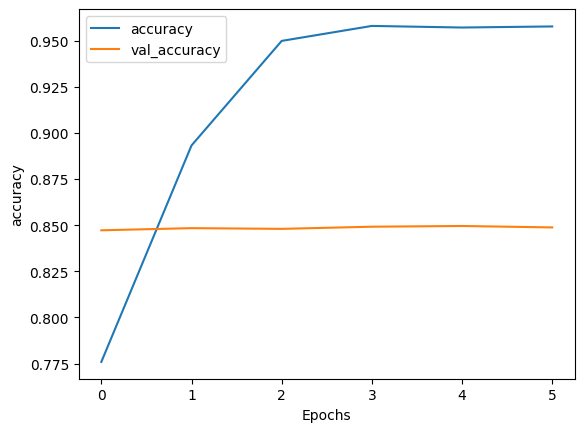

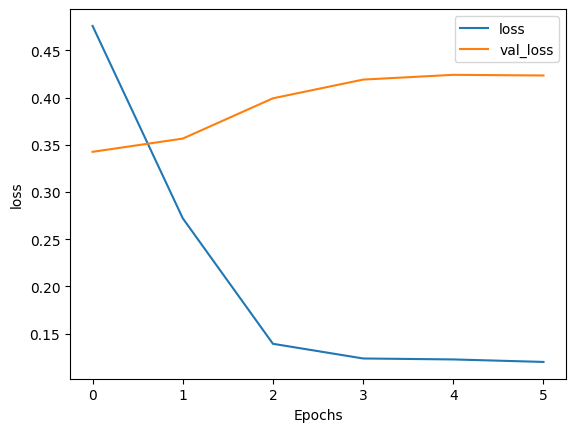

In [186]:
history = histroy

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [187]:
    cnn_predictions = (model.predict(X_test)> 0.5).astype("int32")
    print("Accuracy: %.2f%%" % (accuracy_score(test_l, cnn_predictions)*100))
    print(classification_report(test_l, cnn_predictions))
    display(pd.DataFrame(confusion_matrix(test_l, cnn_predictions)))

90/90 [==============================] - 0s 2ms/step
Accuracy: 85.13%
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1516
           1       0.83      0.85      0.84      1335

    accuracy                           0.85      2851
   macro avg       0.85      0.85      0.85      2851
weighted avg       0.85      0.85      0.85      2851



,0,1
0,1289,227
1,197,1138


# 6) BERT with NLP Aug

In [170]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [171]:
def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks, all_segments= [], [], []
    for doc in docs:
        
        tokens = tokenizer.tokenize(doc)
        
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids) # [1,1,1.....] # 500 ones
        
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
            
        segments = [0] * max_seq_length # [0,0,0...] # 500 zeros
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)
        
    encoded = np.array([all_ids, all_masks, all_segments])
    
    return encoded

In [172]:
MAX_SEQ_LENGTH = 20

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_segment_ids")

train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer, 
                                                                                               train_hl, 
                                                                                               max_seq_length=MAX_SEQ_LENGTH)

val_features_ids, val_features_masks, val_features_segments = create_bert_input_features(tokenizer, 
                                                                                         val_hl, 
                                                                                         max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape, train_features_segments.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape, val_features_segments.shape)

Train Features: (46111, 20) (46111, 20) (46111, 20)
Val Features: (2566, 20) (2566, 20) (2566, 20)


In [173]:
#build the model

inputs = [inp_id, inp_mask, inp_segment]

hidden_state = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs)
pooled_output = hidden_state[1]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bert_input_ids (InputLayer  [(None, 20)]                 0         []                            
 )                                                                                                
                                                                                                  
 bert_input_masks (InputLay  [(None, 20)]                 0         []                            
 er)                                                                                              
                                                                                                  
 bert_segment_ids (InputLay  [(None, 20)]                 0         []                            
 er)                                                                                        

In [174]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)
history = model.fit([train_features_ids, 
           train_features_masks, 
           train_features_segments], train_l, 
          validation_data=([val_features_ids, 
                            val_features_masks, 
                            val_features_segments], val_l),
          epochs=15, 
          batch_size=32, 
          callbacks=[es],
          shuffle=True,
          verbose=1)

Epoch 1/15
1441/1441 [==============================] - 164s 98ms/step - loss: 0.4049 - accuracy: 0.8081 - val_loss: 0.2928 - val_accuracy: 0.8862
Epoch 2/15
1441/1441 [==============================] - 136s 94ms/step - loss: 0.2398 - accuracy: 0.8996 - val_loss: 0.2269 - val_accuracy: 0.9147
Epoch 3/15
1441/1441 [==============================] - 136s 94ms/step - loss: 0.1267 - accuracy: 0.9509 - val_loss: 0.2797 - val_accuracy: 0.9147
Epoch 4/15
1441/1441 [==============================] - 136s 94ms/step - loss: 0.0611 - accuracy: 0.9775 - val_loss: 0.3431 - val_accuracy: 0.9123
Epoch 4: early stopping


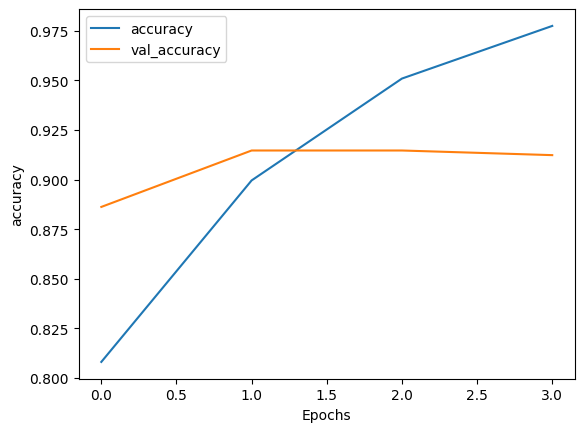

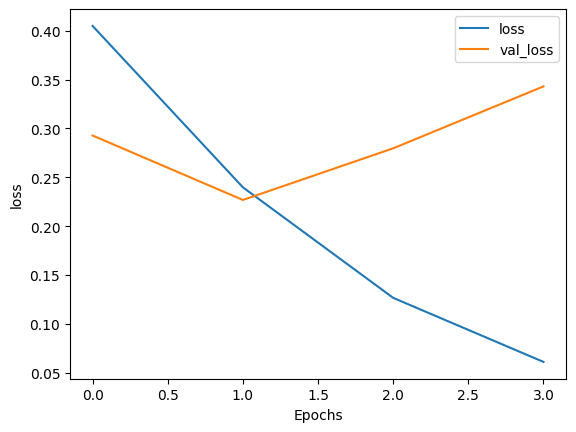

In [175]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [176]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer, 
                                                                                            test_hl, 
                                                                                            max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Test Features: (2851, 20) (2851, 20) (2851, 20)


In [177]:

bert_predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks, 
                                            test_features_segments], verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_l, bert_predictions)*100))
print(classification_report(test_l, bert_predictions))
pd.DataFrame(confusion_matrix(test_l, bert_predictions))

Accuracy: 92.56%
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1516
           1       0.90      0.94      0.92      1335

    accuracy                           0.93      2851
   macro avg       0.93      0.93      0.93      2851
weighted avg       0.93      0.93      0.93      2851



,0,1
0,1380,136
1,76,1259


# 6) Bert with easy augment

In [284]:
train_hl = train_hl_p_eag
train_l = train_l_eag

In [285]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [286]:
def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks, all_segments= [], [], []
    for doc in docs:
        
        tokens = tokenizer.tokenize(doc)
        
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids) # [1,1,1.....] # 500 ones
        
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
            
        segments = [0] * max_seq_length # [0,0,0...] # 500 zeros
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)
        
    encoded = np.array([all_ids, all_masks, all_segments])
    
    return encoded

In [287]:
MAX_SEQ_LENGTH = 20

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_segment_ids")

train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer, 
                                                                                               train_hl, 
                                                                                               max_seq_length=MAX_SEQ_LENGTH)

val_features_ids, val_features_masks, val_features_segments = create_bert_input_features(tokenizer, 
                                                                                         val_hl, 
                                                                                         max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape, train_features_segments.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape, val_features_segments.shape)

Train Features: (46100, 20) (46100, 20) (46100, 20)
Val Features: (2566, 20) (2566, 20) (2566, 20)


In [288]:
#build the model

inputs = [inp_id, inp_mask, inp_segment]

hidden_state = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs)
pooled_output = hidden_state[1]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bert_input_ids (InputLayer  [(None, 20)]                 0         []                            
 )                                                                                                
                                                                                                  
 bert_input_masks (InputLay  [(None, 20)]                 0         []                            
 er)                                                                                              
                                                                                                  
 bert_segment_ids (InputLay  [(None, 20)]                 0         []                            
 er)                                                                                        

In [289]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)
history = model.fit([train_features_ids, 
           train_features_masks, 
           train_features_segments], train_l, 
          validation_data=([val_features_ids, 
                            val_features_masks, 
                            val_features_segments], val_l),
          epochs=15, 
          batch_size=32, 
          callbacks=[es],
          shuffle=True,
          verbose=1)

Epoch 1/15
1441/1441 [==============================] - 168s 100ms/step - loss: 0.2866 - accuracy: 0.8757 - val_loss: 0.2753 - val_accuracy: 0.8936
Epoch 2/15
1441/1441 [==============================] - 143s 99ms/step - loss: 0.0950 - accuracy: 0.9660 - val_loss: 0.2836 - val_accuracy: 0.9108
Epoch 3/15
1441/1441 [==============================] - 145s 101ms/step - loss: 0.0329 - accuracy: 0.9892 - val_loss: 0.4720 - val_accuracy: 0.8963
Epoch 3: early stopping


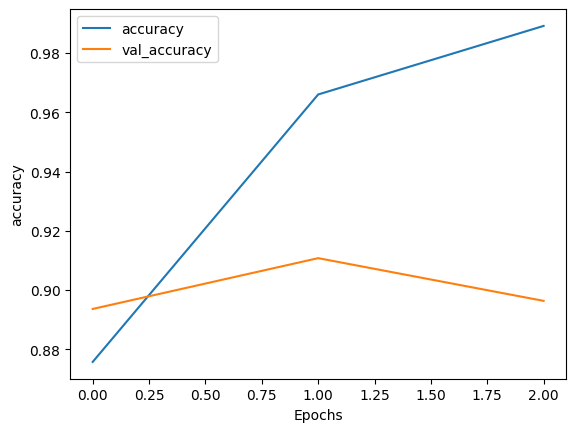

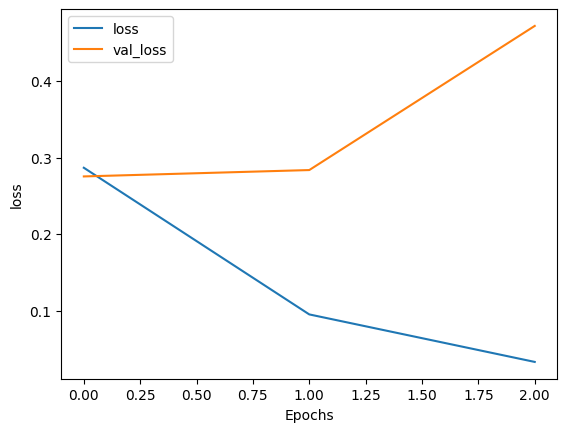

In [290]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [291]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer, 
                                                                                            test_hl, 
                                                                                            max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Test Features: (2851, 20) (2851, 20) (2851, 20)


In [292]:

bert_predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks, 
                                            test_features_segments], verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_l, bert_predictions)*100))
print(classification_report(test_l, bert_predictions))
pd.DataFrame(confusion_matrix(test_l, bert_predictions))

Accuracy: 90.49%
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1516
           1       0.95      0.84      0.89      1335

    accuracy                           0.90      2851
   macro avg       0.91      0.90      0.90      2851
weighted avg       0.91      0.90      0.90      2851



,0,1
0,1463,53
1,218,1117
